# Customizing the density estimator


`sbi` allows to specify a specific density estimator for each of the implemented methods.
We support a variety of density estimators, e.g., mixtures of Gaussians, normalizing
flows, and diffusion models. Some of the density estimators are implemented as part of
`sbi`, for others we rely on other packages like
[`nflows`](https://github.com/bayesiains/nflows/) (via `pyknos`) or [`zuko`](https://github.com/probabilists/zuko). 

For all options, check the API reference
[here](https://sbi.readthedocs.io/en/latest/reference/sbi.models.html).


## Changing the type of density estimator

One option is using one of the preconfigured density estimators by passing a string in
the `density_estimator` keyword argument to the inference object (`NPE` or `NLE`), e.g.,
"maf" for a Masked Autoregressive Flow, of "nsf" for a Neural Spline Flow with default
hyperparameters.

**New with sbi 0.23:** Note that `"maf"` or `"nsf"` correspond to `nflows` density
estimators. Those have proven to work well, but the `nflows` package is not maintained
anymore. To use more recent and actively maintained density estimators, we tentatively
recommend using `zuko`, e.g., by passing `zuko_maf` or `zuko_nsf`. 


In [1]:
import torch

from sbi.analysis import pairplot
from sbi.inference import NPE, NRE
from sbi.utils import BoxUniform

/Users/nastyakrouglova/anaconda3/envs/sbi_dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prior = BoxUniform(torch.zeros(2), torch.ones(2))
inference = NPE(prior=prior, density_estimator="zuko_maf")

In the case of `NRE`, the argument is called `classifier`:


In [3]:
inference = NRE(prior=prior, classifier="resnet")

## Changing hyperparameters of density estimators


Alternatively, you can use a set of utils functions to configure a density estimator yourself, e.g., use a MAF with hyperparameters chosen for your problem at hand.

Here, because we want to use N*P*E, we specifiy a neural network targeting the _posterior_ (using the utils function `posterior_nn`). In this example, we will create a neural spline flow (`'nsf'`) with `60` hidden units and `3` transform layers:


In [4]:
# For SNLE: likelihood_nn(). For SNRE: classifier_nn()
from sbi.neural_nets import posterior_nn
from sbi.utils.user_input_checks import (
    process_prior,
    process_simulator,
)

prior = BoxUniform(-2* torch.ones(2), 2*torch.ones(2))
def simulator(theta):
    # linear gaussian
    return theta + 3.0 + torch.randn_like(theta) * 0.4

prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator, prior, prior_returns_numpy)

In [ ]:
density_estimator_build_fun = posterior_nn(
    model="zuko_nsf", hidden_features=60, num_transforms=3, z_score_theta="independent", x_dist=prior #last element is never logit transformed actually
)

inference = NPE(prior=prior, density_estimator=density_estimator_build_fun)

In [6]:
num_simulations = 10000
theta = prior.sample((num_simulations,))
x = simulator(theta)

inference = inference.append_simulations(theta, x)

In [7]:
density_estimator = inference.train()

 Neural network successfully converged after 88 epochs.

In [8]:
posterior = inference.build_posterior(density_estimator)

Drawing 10000 posterior samples for 1 observations: 100%|██████████| 10000/10000 [00:00<00:00, 279268.39it/s]


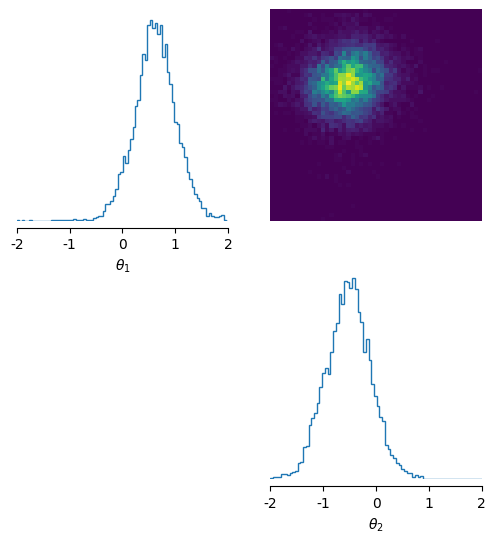

In [9]:


theta_true = prior.sample((1,))
# generate our observation
x_obs = simulator(theta_true)

samples = posterior.sample((10000,), x=x_obs)
_ = pairplot(samples,
             limits=[[-2, 2], [-2, 2], [-2, 2]],
             figsize=(6, 6),
             labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])

It is also possible to pass an `embedding_net` to `posterior_nn()` to automatically
learn summary statistics from high-dimensional simulation outputs. You can find a more
detailed tutorial on this in [04_embedding_networks](https://sbi.readthedocs.io/en/latest/tutorials/04_embedding_networks.html).


## Building new density estimators from scratch


Finally, it is also possible to implement your own density estimator from scratch, e.g., including embedding nets to preprocess data, or to a density estimator architecture of your choice.

For this, the `density_estimator` argument needs to be a function that takes `theta` and `x` batches as arguments to then construct the density estimator after the first set of simulations was generated. Our factory functions in `sbi/neural_nets/factory.py` return such a function.

The returned `density_estimator` object needs to be a subclass of [`DensityEstimator`](https://sbi-dev.github.io/sbi/reference/#sbi.neural_nets.density_estimators.DensityEstimator), which requires to implement three methods:
    
- `log_prob(input, condition, **kwargs)`: Return the log probabilities of the inputs given a condition or multiple i.e. batched conditions.
- `loss(input, condition, **kwargs)`: Return the loss for training the density estimator.
- `sample(sample_shape, condition, **kwargs)`: Return samples from the density estimator.

See more information on the [Reference API page](https://sbi.readthedocs.io/en/latest/sbi.html).